In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

import cv2

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2023-10-16 16:37:18.059581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Import the dataset with pandas

train_df = pd.read_csv("./datasets/training/metadata.csv")
eval_df = pd.read_csv("./datasets/evaluation/metadata.csv")
test_df = pd.read_csv("./datasets/test/metadata.csv")

train_df['type'] = 'train'
eval_df['type'] = 'eval'
test_df['type'] = 'test'

train_df['file_name'] = train_df['file_name'].apply(lambda x: 'datasets/training/' + x)
eval_df['file_name'] = eval_df['file_name'].apply(lambda x: 'datasets/evaluation/' + x)
test_df['file_name'] = test_df['file_name'].apply(lambda x: 'datasets/test/' + x)

df = pd.concat([train_df, eval_df, test_df]).reset_index(drop=True)


In [3]:
df.head()

,file_name,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,type
0,datasets/training/1.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
1,datasets/training/2.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
2,datasets/training/3.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
3,datasets/training/4.png,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
4,datasets/training/5.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train


<Axes: >

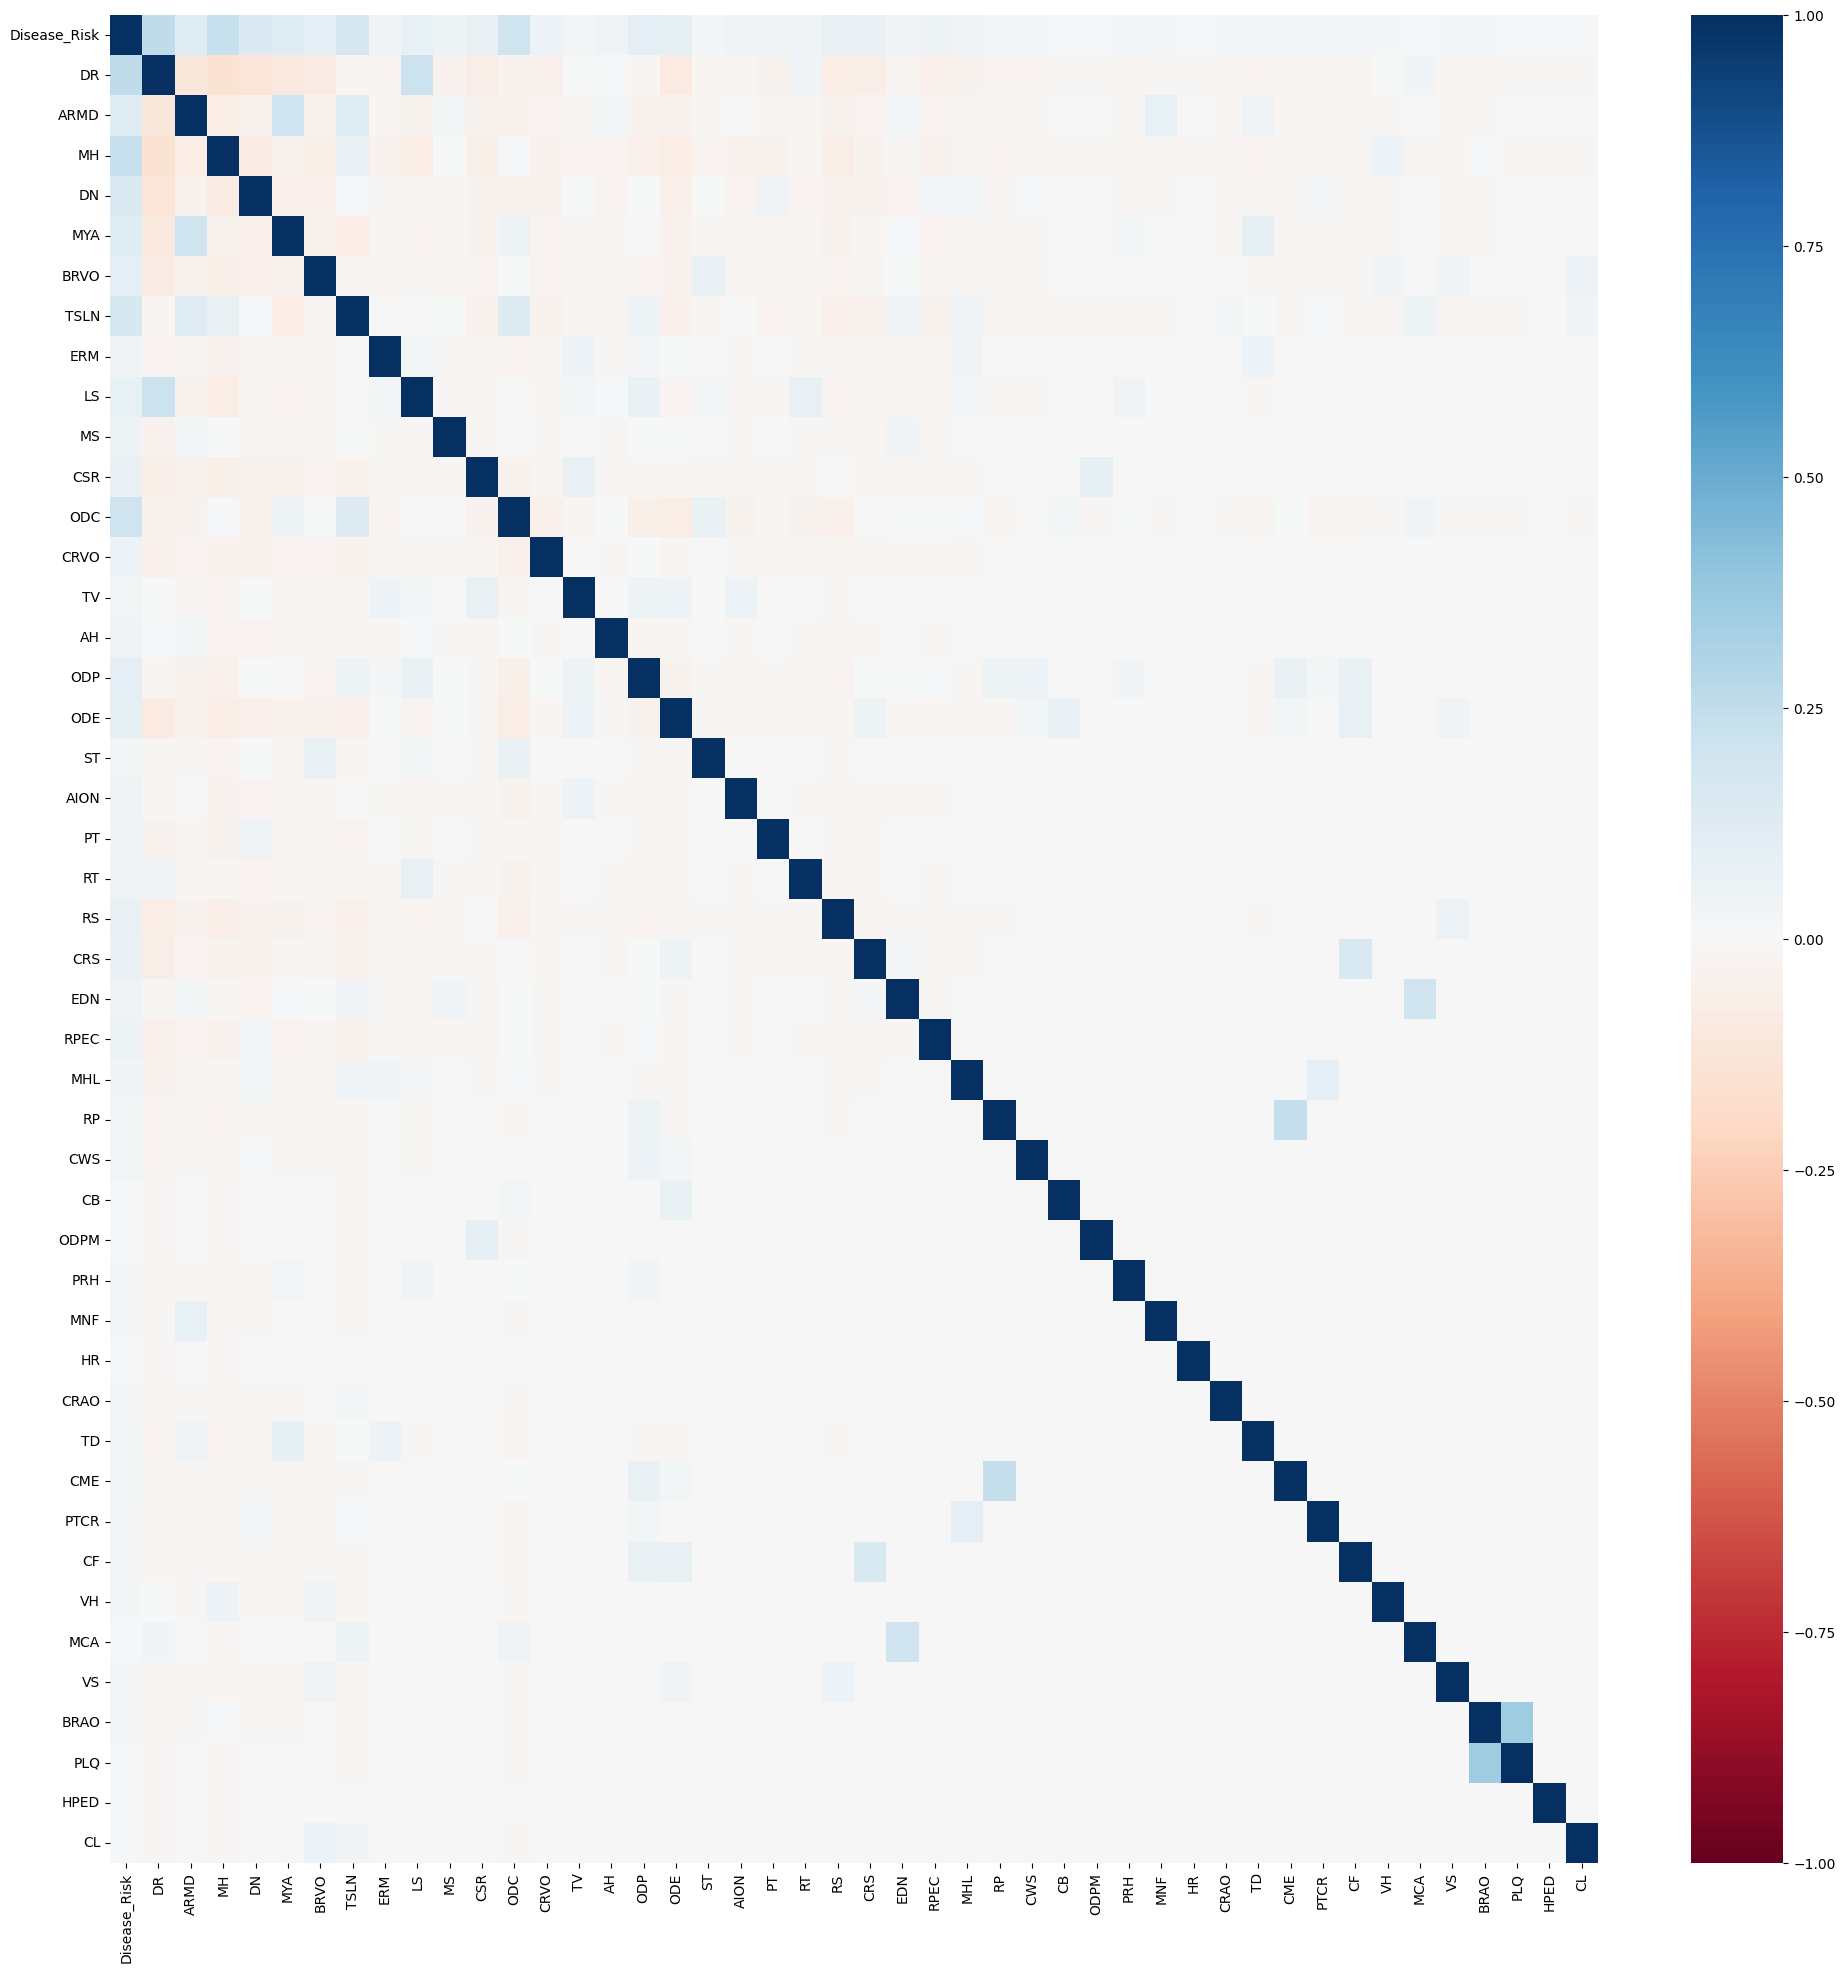

In [4]:
plt.figure(figsize=(24, 24))
sns.heatmap(df.drop(['file_name', 'type'], axis=1).corr(), vmax=1, vmin=-1, cmap="RdBu")

<Axes: >

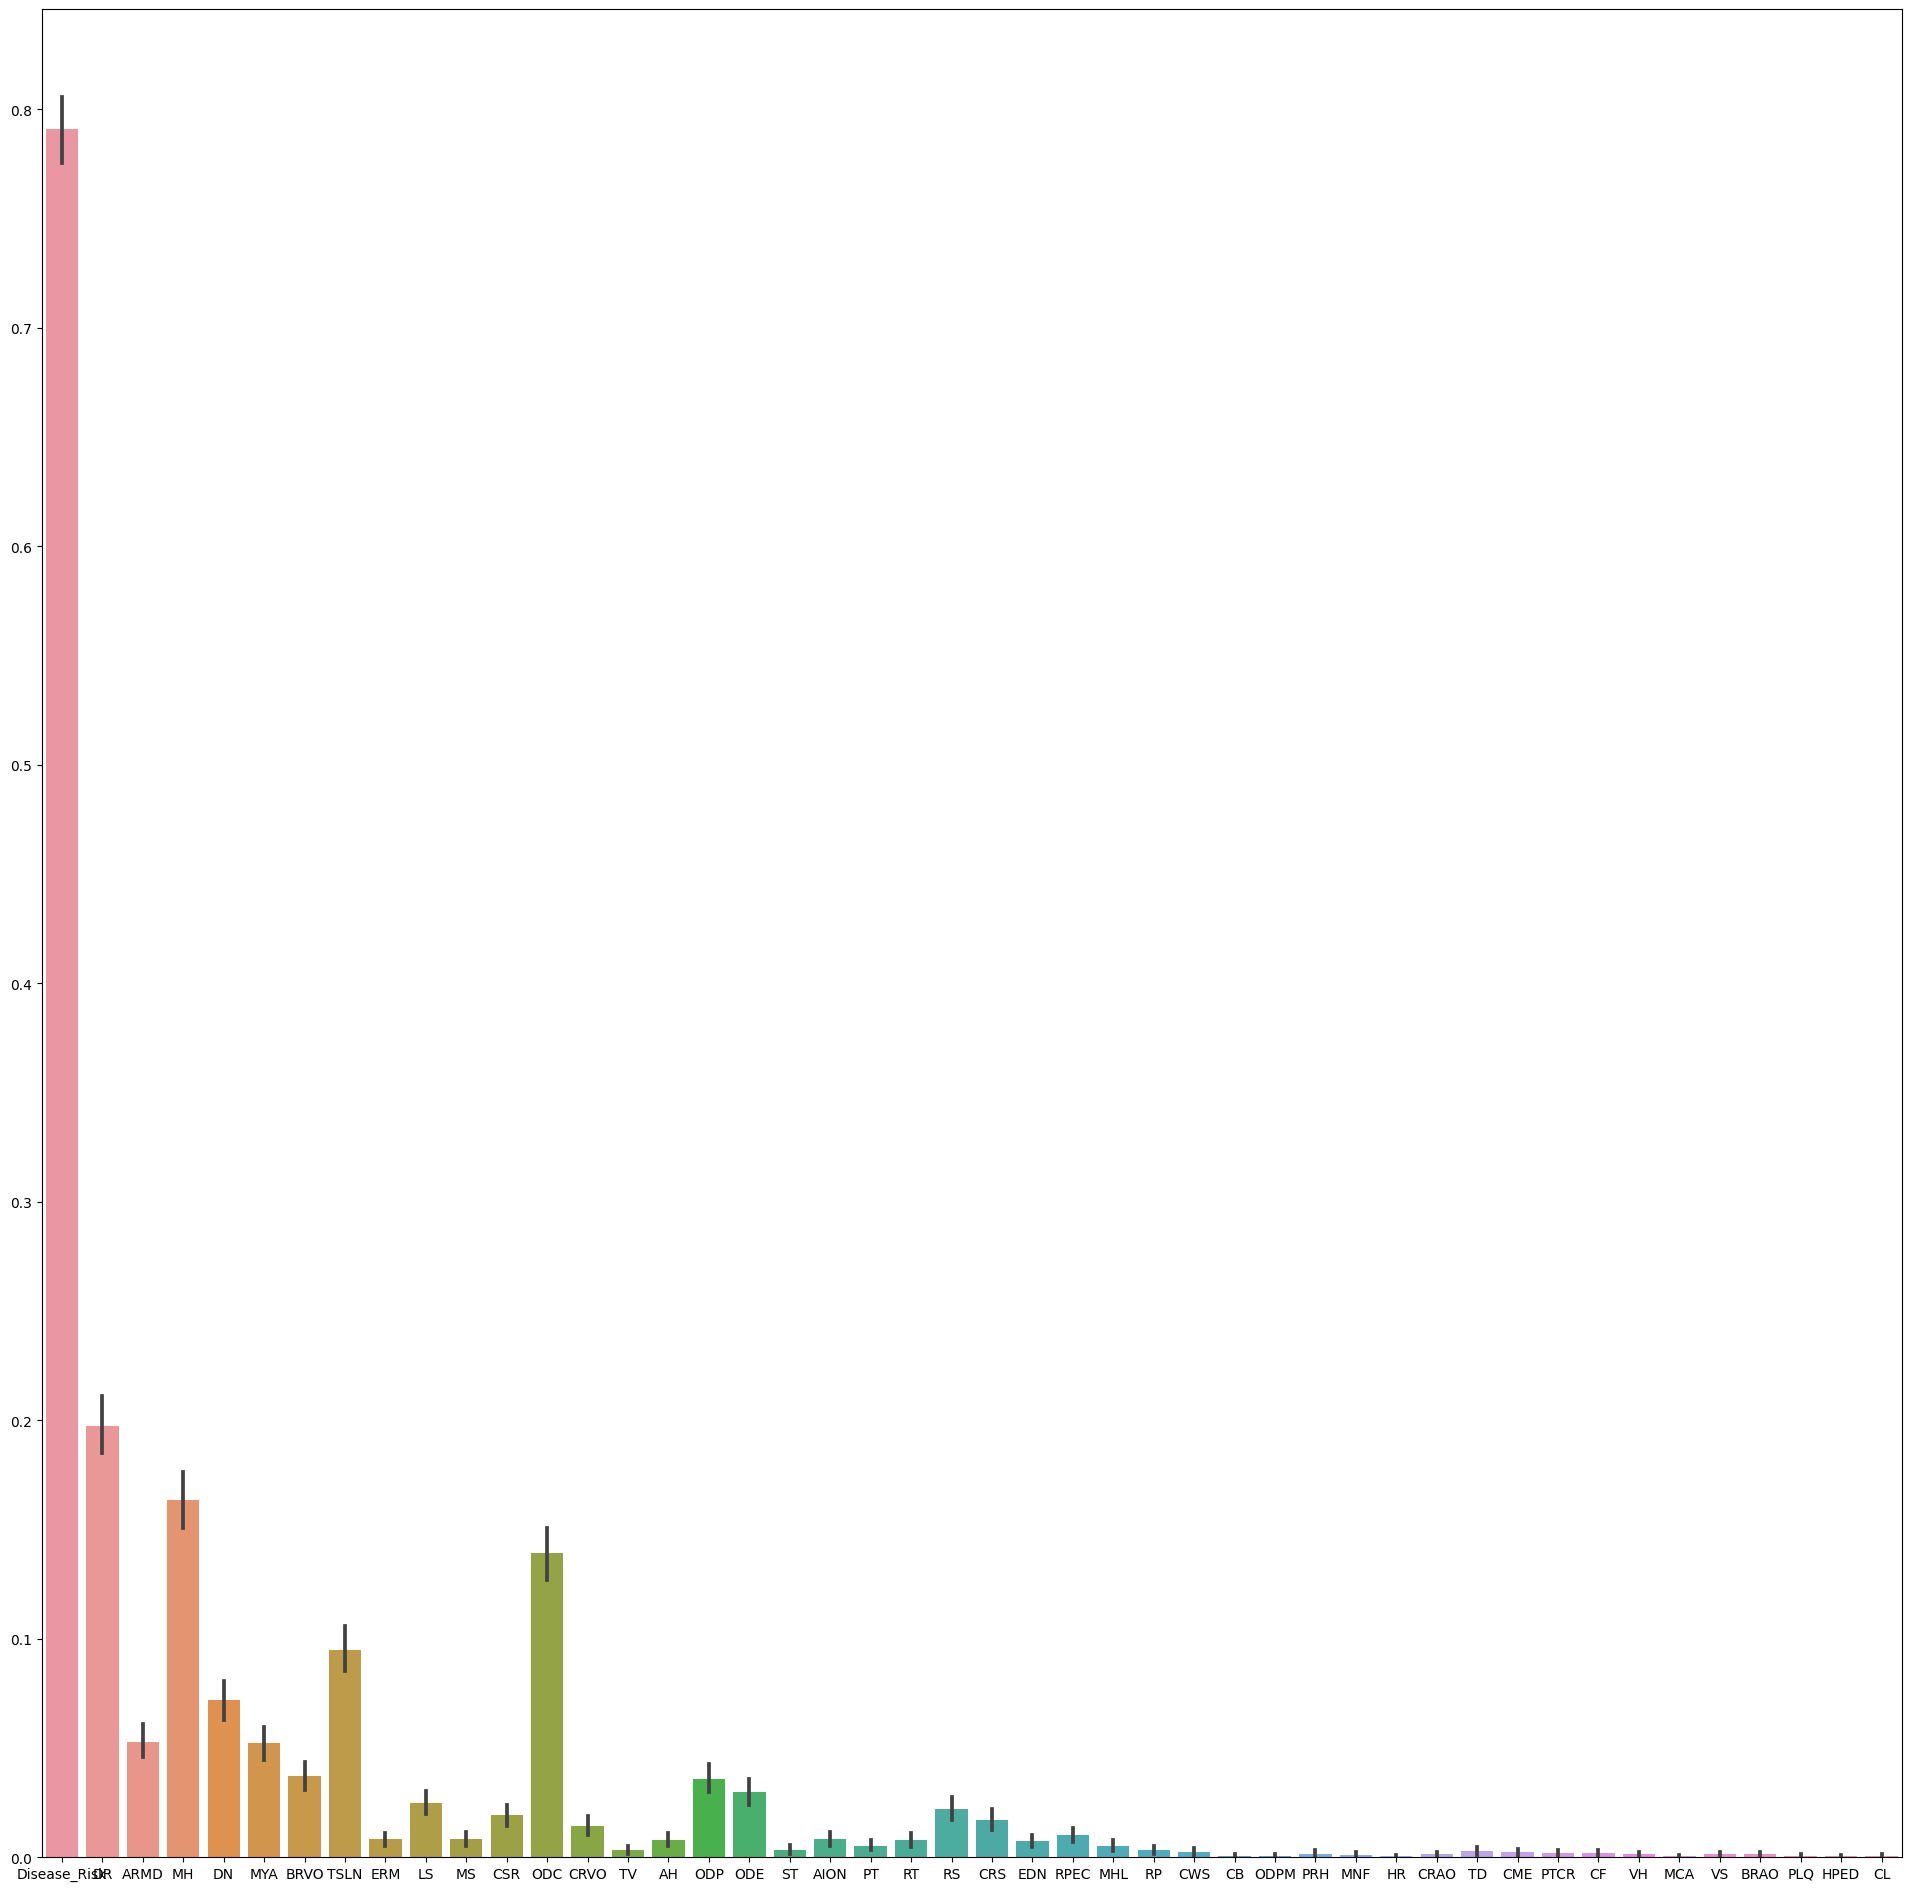

In [5]:
plt.figure(figsize=(24, 24))
sns.barplot(df.drop(['file_name', 'type'], axis=1))

In [6]:
# Remove rare labels for the train set

labels_freq = df.drop(['file_name', 'type'], axis=1)[df['type'] == 'train'].sum(axis=0)

df = df.drop(labels_freq[labels_freq < 50].index, axis=1)

In [7]:
# Encode the labels 0/1
df['label'] = df.apply(lambda x: np.array(df.columns[1:])[x[1:].values == 1], axis=1)

df['label_encoded'] = df.apply(lambda x: (x[1:-1].values == 1).astype(int), axis=1)

In [8]:
df.head(2)

,file_name,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ODC,ODP,ODE,type,label,label_encoded
0,datasets/training/1.png,1,1,0,0,0,0,0,0,0,0,0,train,"[Disease_Risk, DR]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,datasets/training/2.png,1,1,0,0,0,0,0,0,0,0,0,train,"[Disease_Risk, DR]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [9]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024
IMAGE_SIZE = 250
EPOCHS = 10
LABELS_SIZE = len(df['label_encoded'][0])

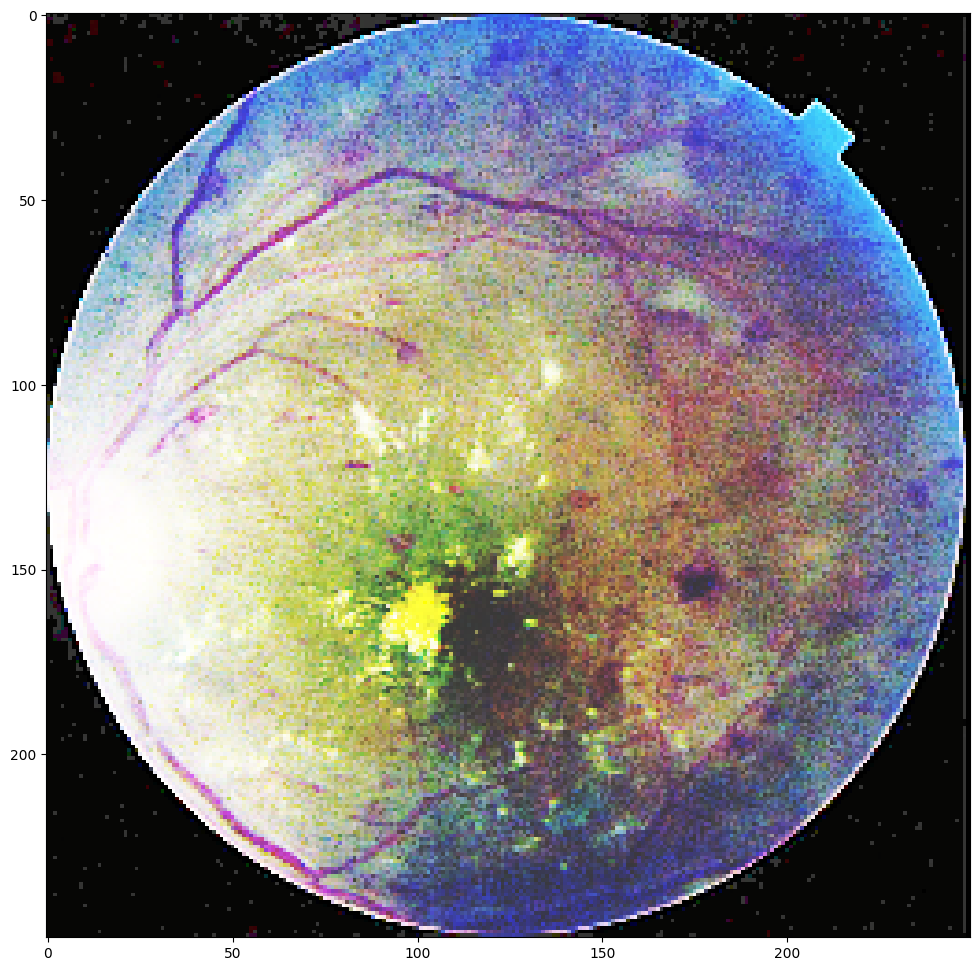

In [33]:
def parse_function(filename:tf.Tensor, label:tf.Tensor)->(tf.float32, tf.int64):
    # Crop the image to remove the black outline
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    
    cv2_image = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2RGB)

    gray_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    x, y, w, h = cv2.boundingRect(cnt)

    image = tf.image.crop_to_bounding_box(image, y, x, h, w)

    image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)

    image = tfa.image.sharpness(image, 3)

    image = tfa.image.equalize(image)

    image = tf.image.random_flip_left_right(image)

    image = tf.image.convert_image_dtype(image/ 255.0, tf.float32) 

    return image, label

# Plot one image
plt.figure(figsize=(12, 12))
plt.imshow(parse_function(df['file_name'][0], df['label_encoded'][0])[0])



In [11]:
def create_dataset(filenames, labels, is_trainable=True):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # Parse and preprocess observations in parallel
    dataset = dataset.map(lambda x, y: tf.py_function(func=parse_function, inp=[x, y], Tout=(tf.float32, tf.int64)), num_parallel_calls=AUTOTUNE)
    
    if is_trainable == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [12]:
train_ds = create_dataset(df[df['type'] == 'train']['file_name'].tolist(), df[df['type'] == 'train']['label_encoded'].tolist())
eval_ds = create_dataset(df[df['type'] == 'eval']['file_name'].tolist(), df[df['type'] == 'eval']['label_encoded'].tolist(), is_trainable=False)
test_ds = create_dataset(df[df['type'] == 'test']['file_name'].tolist(), df[df['type'] == 'test']['label_encoded'].tolist(), is_trainable=False)

In [13]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2023-10-16 16:37:30.023332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1920,12]
	 [[{{node Placeholder/_1}}]]
2023-10-16 16:37:30.023934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]


Shape of features array: (64, 250, 250, 3)
Shape of labels array: (64, 12)


2023-10-16 16:37:58.526830: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(LABELS_SIZE, activation='sigmoid')
])
    

In [15]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [16]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [17]:
import keras.backend as K

@tf.function
def f1_score(y_true, y_pred):
  
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [20]:
from datetime import timedelta
from time import time

start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=eval_ds)
print('\nTraining took {}'.format(timedelta(seconds=time()-start)))

Epoch 1/10


2023-10-16 16:37:59.621651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]
2023-10-16 16:37:59.622472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.


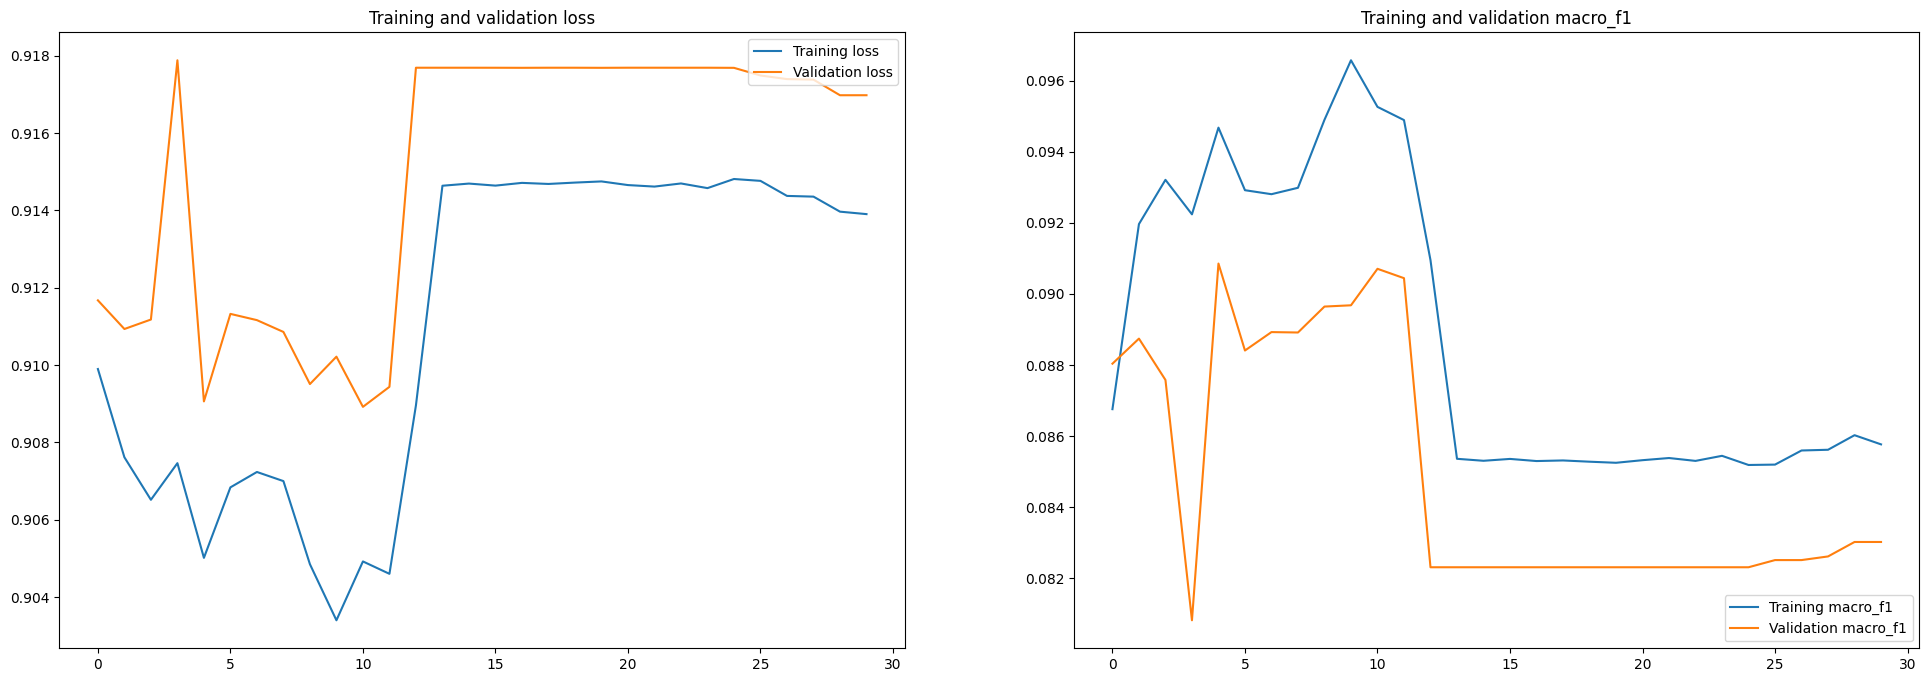

In [ ]:
losses, val_losses, macro_f1s, val_macro_f1s = history.history['loss'], history.history['val_loss'], history.history['macro_f1'], history.history['val_macro_f1']

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

plt.subplot(1, 2, 2)
plt.plot(macro_f1s, label='Training macro_f1')
plt.plot(val_macro_f1s, label='Validation macro_f1')
plt.legend(loc='lower right')
plt.title('Training and validation macro_f1')
plt.show()


In [ ]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.92
Macro F1-score: 0.08
